In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jaxgym.stemoverfocus import (collect_backprojection_coords_and_intensities_jit, 
                                  do_shifted_sum)
import json
import jaxgym.components as comp
%matplotlib widget

Load the Data

In [3]:
fourdstem_array = np.load('fourdstem_array.npy')
params_dict = json.load(open('params.json'))

semi_conv = params_dict['semi_conv']
defocus = params_dict['defocus']
camera_length = params_dict['camera_length']
scan_shape = params_dict['scan_shape'] #YX
det_shape = params_dict['det_shape'] #YX
scan_step = params_dict['scan_step'] #YX
det_px_size = params_dict['det_px_size'] #YX
scan_rotation = params_dict['scan_rotation']
descan_error = params_dict['descan_error']

Make the model

In [4]:
#Create ray input z plane
crossover_z = jnp.zeros((1))

PointSource = comp.PointSource(z=crossover_z, semi_conv=semi_conv)
ScanGrid = comp.ScanGrid(z=jnp.array([params_dict['defocus']]), 
                         scan_step=params_dict['scan_step'], 
                         scan_shape=params_dict['scan_shape'], 
                         scan_rotation=params_dict['scan_rotation'])

Descanner = comp.Descanner(z=jnp.array([params_dict['defocus']]), 
                           descan_error=params_dict['descan_error'], 
                           offset_x=0., 
                           offset_y=0.)

Detector = comp.Detector(z=jnp.array([params_dict['camera_length']]), 
                         det_shape=params_dict['det_shape'], 
                         det_pixel_size=params_dict['det_px_size'])

model = [PointSource, ScanGrid, Descanner, Detector]

In [5]:
shifted_sum = np.zeros(ScanGrid.scan_shape, dtype=np.complex64)
fourdstem_array = np.reshape(fourdstem_array, (scan_shape[0]*scan_shape[1], det_shape[0], det_shape[1]))

Get the backprojected sample pixels and detector intensities on the scan grid

In [8]:
sample_px_ys, sample_px_xs, detector_intensities = collect_backprojection_coords_and_intensities_jit(model, fourdstem_array)

In [9]:
flat_sample_px_ys = np.array(sample_px_ys.flatten())
flat_sample_px_xs = np.array(sample_px_xs.flatten())
flat_detector_intensities = np.array(detector_intensities.flatten())

shifted_sum_image = np.zeros(scan_shape, dtype=np.complex64)
shifted_sum = do_shifted_sum(shifted_sum_image, flat_sample_px_ys, flat_sample_px_xs, flat_detector_intensities)

Ready for interactive portion and libertem.

Text(0.5, 1.0, 'Shifted Sum Image')

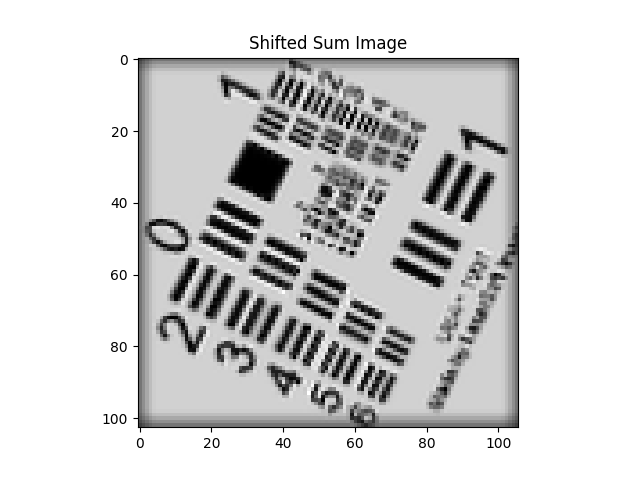

In [11]:
plt.figure()
plt.imshow(np.abs(shifted_sum), cmap='gray')
plt.title('Shifted Sum Image')